In [1]:

import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

import tensorflow_datasets as tfds
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np
from jax import jit

sns.set()

from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions


2024-01-17 15:13:06.592336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 15:13:06.592368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 15:13:06.593781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 15:13:07.339111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

%cd /home/zyuanjue/repos/active-learning/mnistvae

/home/zyuanjue/repos/active-learning/mnistvae


In [3]:
key = jax.random.PRNGKey(0)

model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=1, n_latents=2, key=model_key)
model = eqx.tree_deserialise_leaves("equinoxvae.eqx", model)

2024-01-17 15:13:20.859711: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:407] There was an error before creating cudnn handle (2): cudaErrorMemoryAllocation : out of memory


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [ ]:
from acquiring.sample_image import sample_a_image, get_next,update_images, binary_cross_entropy

In [ ]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
random_seed = 42
def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
#    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [25]:
BATCH_SIZE = 16
#train_dataloader = load_dataset(tfds.Split.TRAIN, BATCH_SIZE)
test_dataloader = load_dataset(tfds.Split.TEST,BATCH_SIZE)
batch = next(test_dataloader)
batch['image'].shape

2024-01-17 14:54:13.139407: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(16, 28, 28, 1)

In [ ]:
from acquiring.random_baseline import random_get_next

In [ ]:
Nz = 10
Nx = 5


sample_a_image_fn = jax.vmap(sample_a_image, in_axes=(None, None, 0, None, 0))
get_next_fn = jax.vmap(get_next)
update_images_fn = jax.vmap(update_images)
random_get_next_fn = jax.vmap(random_get_next)

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))

model_fn = jax.vmap(model)
keys = jax.random.split(key, BATCH_SIZE)

In [ ]:

def update(images_refill: jnp.ndarray, orginial_images: jnp.ndarray, images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    images = update_images_fn(images, mask_observed)
    batch_rng = jax.random.split(rng, BATCH_SIZE) 
    model_output: ImageVAEOutput = model_fn(images_refill, key=batch_rng)
    R = sample_a_image_fn(Nz, Nx,model_output,model, batch_rng)
    
    images_updated, mask_return = get_next_fn(R, mask_observed, images,orginial_images)
    
    return images_updated, mask_return

def random_update(original_random:jnp.array, images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    batch_rng = jax.random.split(rng, BATCH_SIZE)
    images_updated, mask_return, index = random_get_next_fn(mask_observed, images, original_random, batch_rng)
    #print(f"rand_mask : {jnp.sum(mask_return [0])}+ {jnp.sum(~mask_return [0])}")
    return images_updated, mask_return

5.649084568023682

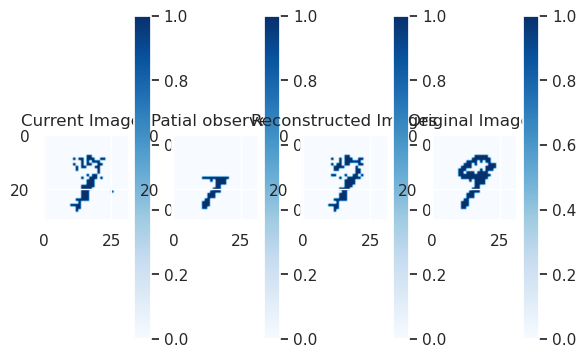

In [26]:
#DEMO
original_images = jnp.squeeze(batch['image'])
original_images = original_images.astype(jnp.float32)
original_images= pad_fn(original_images)

half_height = original_images.shape[1] // 2

images_with_top_half_missing = original_images.copy()
images_with_top_half_missing = images_with_top_half_missing.at[:, :half_height, :].set(jnp.nan)
mask_missing = jnp.isnan(images_with_top_half_missing)
mask_observed = ~mask_missing

batch_rng = jax.random.split(key, BATCH_SIZE) 
model_output: ImageVAEOutput = model_fn(original_images, key=batch_rng)
reconstruction_img = model_output["observation_distribution"].sample(seed=key)
reconstruction_img =jnp.squeeze(reconstruction_img).astype(jnp.float32)
    #print(f"original_img:{original_images.shape} recon_img:{reconstruction_img.shape}")

images_refill = update_images_fn(original_images, mask_observed) #orginal img  half replaced 
curr_output: ImageVAEOutput = model_fn(images_refill, key=batch_rng)
current_images = curr_output["observation_distribution"].sample(seed=key)
current_images = jnp.squeeze(current_images).astype(jnp.float32)

plt.subplot(1, 4, 1)
plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.title("Current Images")

plt.subplot(1, 4, 2)
plt.imshow(images_refill[0], cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.title("Patial observed")

plt.subplot(1, 4, 3)
plt.imshow(reconstruction_img[0], cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.title("Reconstructed Images")

plt.subplot(1, 4, 4)
plt.imshow(original_images[0], cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.title("Original Images")
"""Reconstruction Distortion(Base case trying to achieve)"""
current_loss = get_evidence_lower_bound(original_images, model_output)
current_loss['distortion'].item()

5.428340911865234


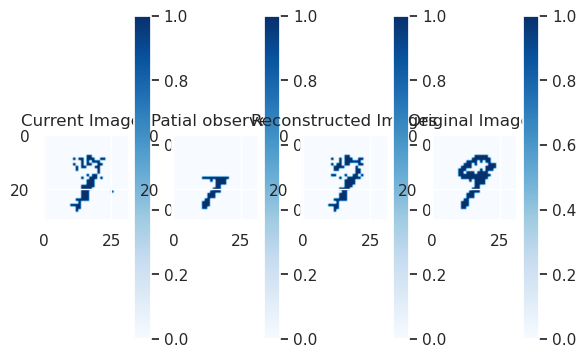

5.473016738891602


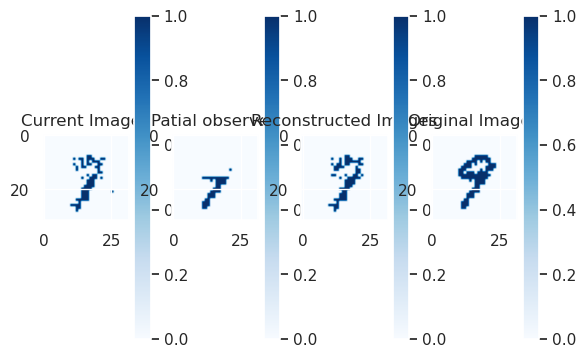

5.532332420349121


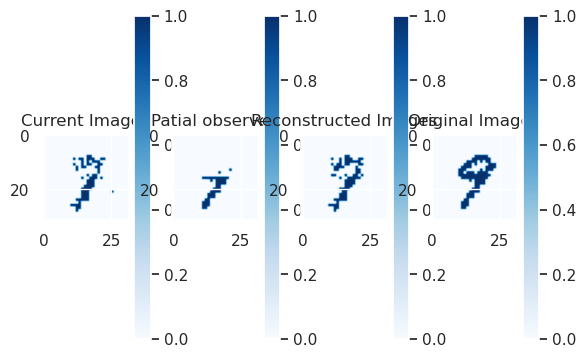

5.528288841247559


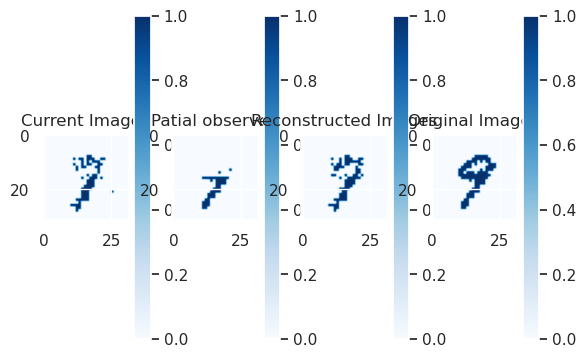

5.521511554718018


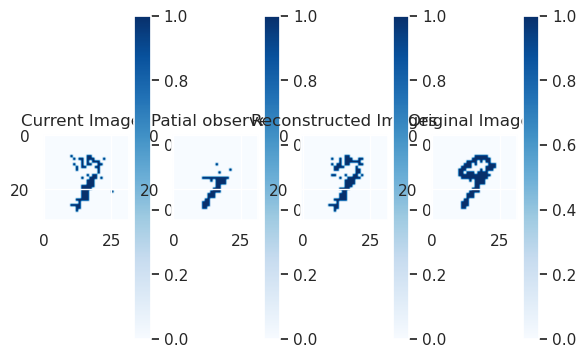

5.59946870803833


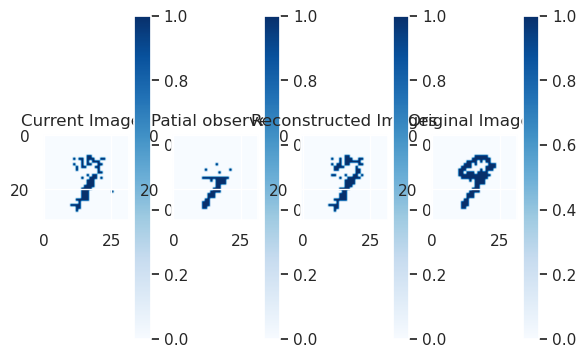

5.603024482727051


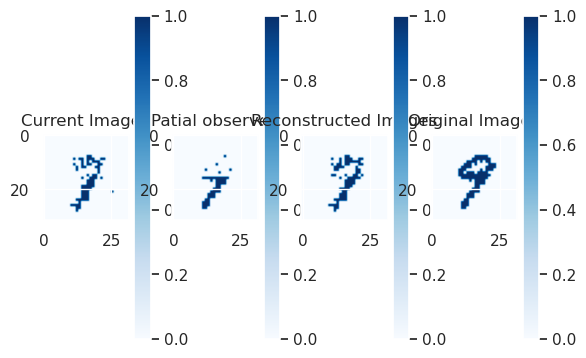

5.604379653930664


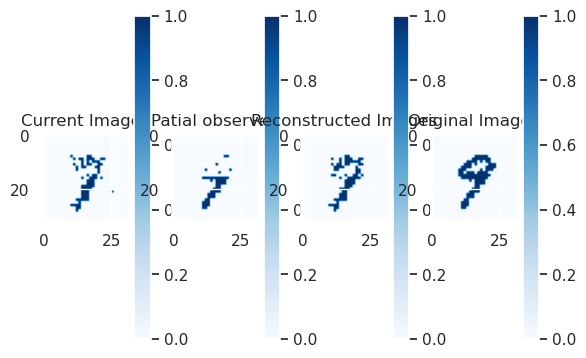

5.629580497741699


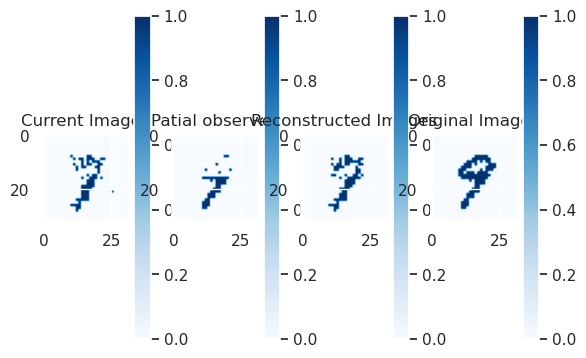

5.632490158081055


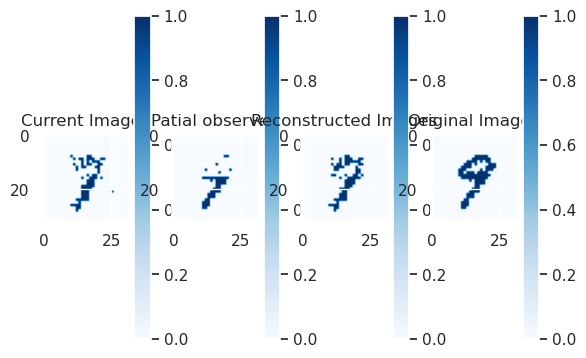

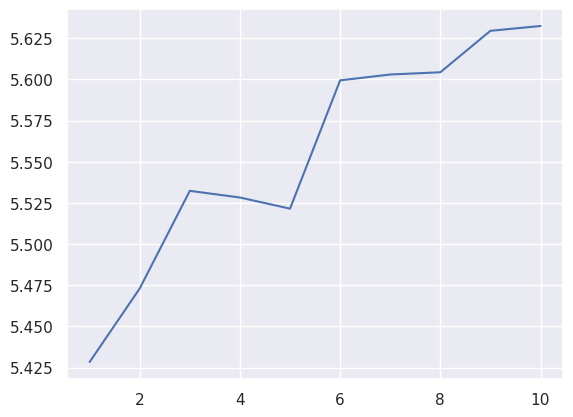

In [32]:
current_mask = mask_observed

random_images = images_refill
random_mask = mask_observed
test_array = []
update = jit(update)
current_images = images_refill
step = 0
for _ in range(10):
    current_images, current_mask = update(images_refill, original_images, current_images, current_mask, key)
    current_output: ImageVAEOutput = model_fn(current_images, key=batch_rng)
    current_reconstruction = current_output["observation_distribution"].sample(seed=key)
    current_reconstruction = jnp.squeeze(current_reconstruction).astype(jnp.float32)
    current_loss = get_evidence_lower_bound(original_images, current_output)
    distortion = current_loss['distortion'].item()
    test_array.append(distortion)
    step += 1
    if step % 1 == 0:
        print(distortion)
        plt.subplot(1, 4, 1)
        plt.imshow(current_reconstruction[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.title("Current Images")

        plt.subplot(1, 4, 2)
        plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.title("Patial observed")

        plt.subplot(1, 4, 3)
        plt.imshow(reconstruction_img[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.title("Reconstructed Images")

        plt.subplot(1, 4, 4)
        plt.imshow(original_images[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.title("Original Images")

        plt.show()
steps = jnp.arange(1, 11) 
plt.figure()
plt.plot(steps,test_array)    

In [ ]:
display_batch_number = 1
batch_counter = 0
log_likelihood = []
full_recon_loss = []
step_numbers = []

random_recon =[]

update = jit(update)
random_update = jit(random_update)

for batch_index, batch in enumerate(test_dataloader):
    
    # Load and preprocess the batch
    original_images = jnp.squeeze(batch['image'])
    original_images = original_images.astype(jnp.float32)
    original_images= pad_fn(original_images)

    half_height = original_images.shape[1] // 2

    # Create mask and images with missing data
    images_with_top_half_missing = original_images.copy()
    images_with_top_half_missing = images_with_top_half_missing.at[:, :half_height, :].set(jnp.nan)
    mask_missing = jnp.isnan(images_with_top_half_missing)
    mask_observed = ~mask_missing

    #images_refill = update_images_fn(original_images, mask_observed)
   # mask_observed = pad_fn(mask_observed)
    #images_refill = pad_fn(images_refill)
    """Instead of using orginal_images, we use the reconstruced images."""
    batch_rng = jax.random.split(key, BATCH_SIZE) 
    model_output: ImageVAEOutput = model_fn(original_images, key=batch_rng)
    reconstruction_img = model_output["observation_distribution"].sample(seed=key)
    reconstruction_img =jnp.squeeze(reconstruction_img).astype(jnp.float32)
    #print(f"original_img:{original_images.shape} recon_img:{reconstruction_img.shape}")
    images_refill = update_images_fn(reconstruction_img, mask_observed)

    current_images = images_refill
    current_mask = mask_observed

    random_images = images_refill
    random_mask = mask_observed

    steps = 20  #display freq
    step_counter = 0

    fully_loss = -binary_cross_entropy(original_images,reconstruction_img)
    full_recon_loss.append(-jnp.mean(fully_loss))
    for _ in range(32*32):
        current_images, current_mask = update(images_refill,  reconstruction_img , current_images, current_mask, key)
        random_images, random_mask = random_update(reconstruction_img , random_images, random_mask, key)

        new_log_likelihood_recon = -binary_cross_entropy( original_images, current_images)
        random_log_likelihood = -binary_cross_entropy( original_images , random_images)

        log_likelihood.append(-jnp.mean(new_log_likelihood_recon))
        random_recon.append(-jnp.mean(random_log_likelihood))


        if batch_index == display_batch_number:
            if step_counter % steps == 0:
                # print(f"Step {step_counter}:  Log Likelihood = {jnp.mean(new_log_likelihood_recon)}")
                # print(f"Step {step_counter}:  Random Log Likelihood = {jnp.mean(random_log_likelihood)}")
                # print(f"Step {step_counter}:  Fully loss= {jnp.mean(fully_loss)}")
                print(f"Step {step_counter}:  Log Likelihood = {new_log_likelihood_recon[0]}")
                print(f"Step {step_counter}:  Random Log Likelihood = {random_log_likelihood[0]}")
                print(f"Step {step_counter}:  Fully loss= {fully_loss[0]}")


                if step_counter < 800:
                    plt.subplot(1, 3, 1)
                    plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
                    plt.colorbar()
                    plt.title("Current Images")
                    
                    plt.subplot(1, 3, 2)
                    plt.imshow(reconstruction_img[0], cmap='Blues', vmin=0, vmax=1)
                    plt.colorbar()
                    plt.title("Reconstructed Images")
                    
                    plt.subplot(1, 3, 3)
                    plt.imshow(original_images[0], cmap='Blues', vmin=0, vmax=1)
                    plt.colorbar()
                    plt.title("Original Images")
                    plt.show()


        step_counter += 1
    
    batch_counter += 1
    if batch_counter == 4:
        break
    print(f"batch{batch_counter}")


In [ ]:
num_batches_to_process = batch_counter
reshaped_batches =jnp.array(log_likelihood).reshape(num_batches_to_process, 1024).transpose(1, 0)
combined_batches = reshaped_batches.reshape(1024, num_batches_to_process)
std_dev_each_step = jnp.std(combined_batches, axis=1, keepdims=True)

In [ ]:

rand_reshaped_batches =jnp.array(random_recon).reshape(num_batches_to_process, 1024).transpose(1, 0)
rand_combined_batches = rand_reshaped_batches.reshape(1024, num_batches_to_process)
rand_std_dev_each_step = np.std(rand_combined_batches, axis=1, keepdims=True)

In [ ]:
mean_values = jnp.mean(combined_batches, axis=1)
rand_values = jnp.mean(rand_combined_batches, axis=1)
full_value = jnp.mean(jnp.array(full_recon_loss))
steps = jnp.arange(1, 1025)  
SD = jnp.std(jnp.array(full_recon_loss))

SE = std_dev_each_step/jnp.sqrt(num_batches_to_process*BATCH_SIZE)
SE_rand = rand_std_dev_each_step/jnp.sqrt(num_batches_to_process*BATCH_SIZE)
SE_full = SD/jnp.sqrt(num_batches_to_process*BATCH_SIZE)

ci = 1.96 * SE.flatten()  # Flatten to ensure it's a 1D array
lower_bound = mean_values - ci
upper_bound = mean_values + ci

ci_rand = 1.96 * SE_rand.flatten()  # Flatten to ensure it's a 1D array
lower_bound_rand = rand_values - ci_rand
upper_bound_rand = rand_values + ci_rand

ci_full = 1.96*SE_full
lower_bound_full = full_value - ci_full
upper_bound_full = full_value + ci_full
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, mean_values, label='Acquisition Reconstruction Value Line')
#plt.plot(712.124)
plt.plot(steps, rand_values, label='Random Acquisition Reconstruction Value Line')

full_value_line = jnp.full_like(jnp.float32(steps), full_value)  # Create an array of full_value repeated
plt.plot(steps, full_value_line, label='Full Reconstruction Value Line')
plt.fill_between(steps, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% CI for Mean Reconstruction Values')
plt.fill_between(steps, lower_bound_rand, upper_bound_rand, color='blue', alpha=0.1, label='95% CI for Random Mean Reconstuction Values')
plt.fill_between(steps, lower_bound_full, upper_bound_full, color='grey', alpha=0.2, label='95% CI for Fully Reconstructed Values')


plt.xlabel('Step Number')
plt.ylabel('Reconstruction Value')
plt.title('Reconstruction Value of Data Points at Each Step')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
rand_values = jnp.mean(rand_combined_batches, axis=1)
rand_values.shape

In [ ]:
#mean_values = jnp.mean(combined_batches, axis=1)
rand_values = jnp.mean(rand_combined_batches, axis=1)
# Create an array for the step numbers
steps = jnp.arange(1, 1025)  # 1024 steps, starting from 1

#SE = std_dev_each_step/jnp.sqrt(num_batches_to_process*BATCH_SIZE)
SE_rand = rand_std_dev_each_step/jnp.sqrt(num_batches_to_process*BATCH_SIZE)

# ci = 1.96 * SE.flatten()  # Flatten to ensure it's a 1D array
# lower_bound = mean_values - ci
# upper_bound = mean_values + ci

ci_rand = 1.96 * SE_rand.flatten()  # Flatten to ensure it's a 1D array
lower_bound_rand = mean_values - ci_rand
upper_bound_rand = mean_values + ci_rand

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(steps, rand_values)
#plt.fill_between(steps, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
#plt.fill_between(steps, lower_bound_rand, upper_bound_rand, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Step Number')
plt.ylabel('Mean Value')
plt.title('Mean Value of Data Points at Each Step')
plt.grid(True)
plt.show()